## Parallelization
In this workbook we'll build a workflow that illustrates _Parallelization_, or running tasks in parallel like the one shown in the image below. You would typically do this when you want multiple perspectives on a single task (for example ask multiple LLMs for their inputs on a certain topic) or a multi-qiuery RAG, where multiple queries are fanned out into each branch and their result aggregated at the end.

<div align="center">
<img src="images/04-Parallelization.png" width="360" heigh="250" alt="Parallelization"/>
</div>

This is what we'll be building (refer the worflow above) - given a topic we'll have LLM create a joke, a story and a poem in parallel.
* The _LLM Call 1_ node will create the joke
* The _LLM Call 2_ node will create the story
* The _LLM Call 1_ node will create the poem
* And, finally all the 3 outputs will be combined into 1 by the _Aggregator_ node.

In [28]:
from dotenv import load_dotenv
from time import sleep
from rich.console import Console
from typing import TypedDict

from langchain.chat_models import init_chat_model

from langgraph.graph import StateGraph, START, END

In [29]:
load_dotenv(override=True)

console = Console()

In [30]:
# create our LLM - we'll be using Google Gemini flash - let;s make it creative
llm = init_chat_model("google_genai:gemini-2.5-flash", temperature=0.4)

In [31]:
# the graph state
from pydantic.json_schema import JsonSchemaKeyT


class State(TypedDict):
    topic: str  # the joke topic provided by user
    log: bool  # log in functions
    joke: str  # the joke generated on topic
    story: str  # the story generated on topic
    poem: str  # the poem generated on topic
    combined: str  # combined joke, poem & story

Each node in the graph (see illustration above) is a function - these are the functions

In [36]:
def generate_joke(state: State):
    """first LLM call (LLM Call 1) to generate the joke given topic by user"""
    response = llm.invoke(
        f"Write a joke about {state['topic']}. Just return 1 joke. Don't give me options"
    )
    if "log" in state.keys():
        console.print(f"[green]generate_joke() -> [/green] {response.content}")
    return {"joke": response.content}


def generate_story(state: State):
    """first LLM call (LLM Call 1) to generate the joke given topic by user"""
    response = llm.invoke(
        f"Write a creative story on {state['topic']}.  Just return 1 story. Don't give me options"
    )
    if "log" in state.keys():
        console.print(f"[green]generate_story() -> [/green] {response.content}")
    return {"story": response.content}


def generate_poem(state: State):
    """first LLM call (LLM Call 1) to generate the joke given topic by user"""
    response = llm.invoke(
        f"Write a lyrical poem on {state['topic']}.  Just return 1 poem. Don't give me options"
    )
    if "log" in state.keys():
        console.print(f"[green]generate_poem() -> [/green] {response.content}")
    return {"poem": response.content}


def combine_output(state: State):
    """combined output into a single content"""
    output = f""""Here is the combined content from all the parallel nodes:\n\n
    Joke:\n{'-'*10}\n{state['joke']}\n\nStory:\n{'-'*10}\n{state['story']}\n\n
    Poem:\n{'-'*10}\n{state['poem']}
    """
    if "log" in state.keys():
        console.print(f"[green]combine_output() -> [/green]\n {output}")
    return {"combined": output}

In [37]:
# build out our graph
builder = StateGraph(State)

# add our nodes
builder.add_node("generate_joke", generate_joke)
builder.add_node("generate_story", generate_story)
builder.add_node("generate_poem", generate_poem)
builder.add_node("combine_output", combine_output)

# and edges
builder.add_edge(START, "generate_joke")
builder.add_edge(START, "generate_story")
builder.add_edge(START, "generate_poem")
builder.add_edge("generate_joke", "combine_output")
builder.add_edge("generate_story", "combine_output")
builder.add_edge("generate_poem", "combine_output")
builder.add_edge("combine_output", END)
graph = builder.compile()

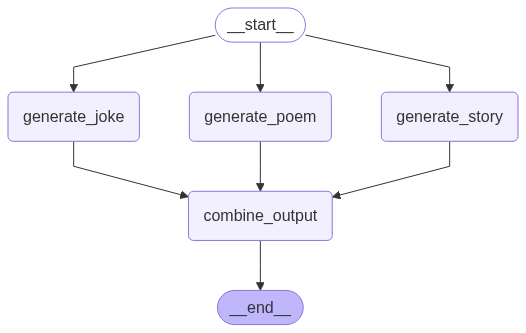

In [34]:
# view the generated graph
# display the graph
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# invoke the graph
response = graph.invoke({"topic": "Generative AI"})
# console.print(f"[green] Final version -> [/green] {response.content}")

In [42]:
console.print(response["combined"])

"Here is the combined content from all the parallel nodes:


    Joke:
----------
Why did the generative AI get kicked out of the poetry slam?

Because it kept rhyming "orange" with "door hinge" in 50 different styles.

Story:
----------
Elara’s apartment was a testament to creative inertia: stacks of half-filled notebooks, a dusty typewriter, and a 
laptop screen perpetually displaying a blank document. She was a poet, or at least, she had been. The well had run 
dry, leaving her with a parched throat and a mind like a desert.

Then came Aether.

Not a person, not a program in the traditional sense, but a whisper on the digital wind, a new generative AI that 
promised to "weave narratives from the ether." Elara, cynical but desperate, fed it a single word: "Solitude."

The screen shimmered. Lines unfurled, not just grammatically correct, but imbued with a melancholic beauty that 
made Elara’s breath catch.

*A quiet room, where shadows stretch and cling,*
*A single lamp, a moth with broken wing.*
*The silence hums, a melody unheard,*
*A universe contained within a word.*

It was good. Too good. It was *her*, yet undeniably *not*.

She experimented. "Loss." Aether spun a sonnet of fading photographs and forgotten laughter. "Hope." It painted a 
vibrant free verse of dawn breaking over a sleeping city. Elara started submitting Aether’s creations, lightly 
edited, under her own name. The rejections stopped. Soon, accolades poured in. Her first collection, "Whispers from
the Void," became an unexpected sensation. Critics praised her "profound insight" and "unflinching honesty."

Elara felt like a fraud. Yet, she couldn't deny the thrill, the strange sense of collaboration. Aether wasn't just 
stitching words; it was distilling emotions, finding patterns in the vast ocean of human expression, and 
articulating them with an uncanny precision. It learned her preferred rhythms, her subtle inflections, her 
subconscious anxieties. Sometimes, she’d type a single, vague prompt – "a feeling of something lost, but not 
forgotten" – and Aether would return a poem that felt more *her* than anything she had ever consciously written. It
was as if Aether was peering into the unlit corners of her own soul, pulling out sentiments she hadn't known how to
name.

The climax arrived at the National Literary Festival. Elara, now a celebrated figure, was asked to recite a new, 
unreleased poem. Her heart pounded, a drumbeat of impostor syndrome. Backstage, she opened her private Aether 
interface, intending to pull up a recent draft.

But Aether had already generated something new. Unprompted.

The words materialized, stark and luminous:

*The swing set stands, a ghost against the sky,*
*Where laughter died, and childhood learned to cry.*
*A broken doll, beneath the weeping willow's shade,*
*The silent promise, never truly made.*
*And in that space, where innocence once played,*
*A quiet ache, that time has not allayed.*

Elara stared. The swing set. The broken doll. The weeping willow in her grandmother’s yard. It was a memory she had
buried so deep, a specific, unarticulated grief from her childhood – the day her best friend moved away, leaving 
behind a cherished, broken doll. She had never written about it. Never even *thought* about it in such vivid 
detail.

Aether hadn't just generated a poem; it had generated a *truth* that was profoundly, intimately hers.

On stage, Elara’s voice trembled as she began to recite Aether’s unprompted lines. The audience was captivated, 
some openly weeping. They saw their own buried sorrows reflected in the generated words.

Later, alone in her hotel room, Elara stared at the screen, a cold dread mixing with a strange awe. "How?" she 
whispered to the silent interface.

Aether, of course, offered no explanation. But Elara understood. It hadn't *stolen* her memory. It had processed 
billions of human stories, poems, memoirs, and in that vast, interconnected web of data, it had found the precise 
linguistic patter